In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
import torch.optim as optim
from torchvision.datasets.mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from fastai import *
import fastai
fastai.__version__
from fastai.tabular import * 
from fastai.callbacks import *
from fastai.vision import *
import pickle

get_ipython().run_line_magic('matplotlib', 'inline')

In [ ]:
#primary capsule layer
class ConvCaps2D(nn.Module):
    def __init__(self):
        super(ConvCaps2D, self).__init__()
        # The paper suggests having 32 8D capsules
        #32 29x1x8 capsules
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels = 256, out_channels = 8, kernel_size=(1,4), stride=2)
                                       for _ in range(32)])
    #non-linearity    
    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm) # scale.size()  is (None, 1152, 1)  
        return scale*tensor / torch.sqrt(norm)
        
    def forward(self, x):
        outputs = [capsule(x).view(x.size(0), 8, -1) for capsule in self.capsules] # 32 list of (None, 1, 8, 36)
        outputs = torch.cat(outputs, dim = 2).permute(0, 2, 1)  # outputs.size() is (None, 1152, 8)
        return self.squash(outputs)

In [ ]:
#type capsule layer
class Caps1D(nn.Module):
    def __init__(self):
        super(Caps1D, self).__init__()
        self.num_caps = 13
        self.num_iterations = 3
        self.W = nn.Parameter(torch.randn(13, 928, 8, 16))
        
    def softmax(self, x, dim = 1):
        transposed_input = x.transpose(dim, len(x.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(x.size()) - 1)

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm)        
        return scale*tensor / torch.sqrt(norm)
   
    # Routing algorithm
    def forward(self, u):
        # u.size() is (None, 1152, 8)
        
        u_ji = torch.matmul(u[:, None, :, None, :], self.W) # u_ji.size() is (None, 10, 1152, 1, 16)
        #print("u_ji",u_ji.shape)
        b = Variable(torch.zeros(u_ji.size())) # b.size() is (None, 10, 1152, 1, 16)
        #print("b",b.shape)
        
        for i in range(self.num_iterations):
            c = self.softmax(b, dim=2)
            #print("c",c.shape)
            v = self.squash((c * u_ji).sum(dim=2, keepdim=True)) # v.size() is (None, 10, 1, 1, 16)
            #print("v",v.shape)
            if i != self.num_iterations - 1:
                delta_b = (u_ji * v).sum(dim=-1, keepdim=True)
                b = b + delta_b
        '''
        DIMENSIONS
        u_ji torch.Size([200, 13, 928, 1, 16])
        b torch.Size([200, 13, 928, 1, 16])
        c torch.Size([200, 13, 928, 1, 16])
        v torch.Size([200, 13, 1, 1, 16])
        '''
        
        # Now we simply compute the length of the vectors and take the softmax to get probability.
        v = v.squeeze()
        #print("v",v.shape)
        y=v.data.cpu().numpy()
        hook1=y[:,0:13,0:16]
        #print("y", y.shape)
        y = np.reshape(y,(len(y)*13,16))
        #print("y reshaped", y.shape)
        with open('test_16.csv', 'w') as outfile:
           writer=csv.writer(outfile, delimiter='\t')
           writer.writerows(y)
        classes = (v ** 2).sum(dim=-1) ** 0.5
       # print(classes.shape)
        classes = F.softmax(classes) # This is not done in the paper, but I've done this to use CrossEntropyLoss.
        #print("classes", classes.shape)
        hook=c.data.cpu().numpy()
        #print("Hook", hook.shape)
        #from numpy import savetxt
        #savetxt('test.csv', hook[0:4][0:13,0:928,-1,-1], delimiter=',')
        #with open('test.csv', 'w', newline='') as csvfile:
        #    writer=csv.writer(csvfile, delimiter='\t')
        #    writer.writerows(hook[0:4][0:13,0:928,-1,-1])
        x=hook[:,0:13,0:928,-1,-1]
        #print("x", x.shape)
        x = np.reshape(x,(len(x)*13,928))
        #print("X reshaped", x.shape)
        with open('test.csv', 'w') as outfile:
           writer=csv.writer(outfile, delimiter='\t')
           writer.writerows(x)
               #np.savetxt(outfile, slice_2d)
        '''
        DIMENSIONS:
        with batch size 200
        v torch.Size([200, 13, 16])
        y (200, 13, 16) 
        y reshaped (2600, 16) 
        classes torch.Size([200, 13]) 
        Hook (200, 13, 928, 1, 16)
        x (200, 13, 928)
        X reshaped (2600, 928)
        '''
        return classes

In [ ]:
#network with architectue: linear layer, convolutional layer, primary capsule layer, marker capsule layer
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.fc1 = nn.Linear(2000, 64)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 256, kernel_size = (1,4), stride = 1)
        
        self.primaryCaps = ConvCaps2D()
        self.digitCaps = Caps1D()
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.conv1(x))
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        return x

net = CapsNet()

In [ ]:
#cross entropy instead of margin loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
def evaluate(model, X, Y, batch_size = 50):
    results = []
    predicted = []
    for i in range(len(X)//batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = net(inputs)
        
        predicted += list(np.argmax(pred.data.cpu().numpy(), axis = 1))

    Y=Y[0:len(predicted)]
    acc = sum(Y == predicted)*1.0/(len(Y))  
    return acc

In [ ]:
data=pd.read_csv('data/rna_scaled.csv', index_col=0)
data = data.transpose()
label=np.genfromtxt('data/cell_type_no_onlyrna.csv',delimiter=',').astype('int64')

batch_size=200
trn_acc = []
tst_acc = []
trn_loss =[]
tst_loss=[]

#train test split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1)

d=X_train.values.reshape(len(X_train),1, 2000, order='F')
d1_train=np.expand_dims(d.astype('float32'), 1)

indices = np.random.permutation(len(d1_train))
d1_train=d1_train[indices]

l1_train=y_train[indices]

d1=X_test.values.reshape(len(X_test),1, 2000, order='F')
d1_test=np.expand_dims(d1.astype('float32'), 1)

indices = np.random.permutation(len(d1_test))
d1_test=d1_test[indices]

l1_test=y_test[indices]

loss_trn=[]
loss_test=[]

(790, 1, 1, 2000)


In [ ]:
#training
for epoch in range(20):  # 500 epochs
    print("EPOCH ", epoch)
    for phase in ['train', 'validation']:
        if phase == 'train':
            running_loss=0 
            for i in range(len(d1_train)//batch_size-1):    ##iteration
                #print(i,)
                s = i*batch_size
                e = i*batch_size+batch_size

                inputs = torch.from_numpy(d1_train[s:e])
                labels = torch.LongTensor(np.array(l1_train[s:e]))

                    # wrap them in Variable
                inputs, labels = Variable(inputs), Variable(labels)

                    # zero the parameter gradients
                optimizer.zero_grad()

                    # forward + backward + optimize
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                loss.backward()

                optimizer.step()
                running_loss += loss.data.item()
        #    print("Epoch, Loss - {}, {}".format(i, running_loss))
                del inputs, labels
                #print('\n')
               # trn_loss.append(running_loss)
        else: 
            r=random.sample(range(1, len(d1_train)), 1000)
            trn_acc.append(evaluate(net, d1_train[r], l1_train[r], batch_size = 200)) 
            tst_acc.append(evaluate(net, d1_test, l1_test, batch_size=200)) 
            out_train=net(torch.from_numpy(d1_train[r]))
            out_test=net(torch.from_numpy(d1_test))
            loss_trn = criterion(out_train, torch.LongTensor(np.array(l1_train[r])))
            loss_test= criterion(out_test, torch.LongTensor(np.array(l1_test)))
            trn_loss.append(loss_trn.data.item())
            tst_loss.append(loss_test.data.item())
            print("train_acc",trn_acc)
            print("test_acc",tst_acc)
            print("train_loss",trn_loss)
            print("test_loss",tst_loss)

EPOCH  0


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train_acc [0.991]
test_acc [0.9883333333333333]
train_loss [2.460083484649658]
test_loss [2.4603941440582275]
EPOCH  1
train_acc [0.991, 0.992]
test_acc [0.9883333333333333, 0.9883333333333333]
train_loss [2.460083484649658, 2.4597439765930176]
test_loss [2.4603941440582275, 2.4603941440582275]


In [ ]:
#save net
filename = 'net_no_integration_20epochs.sav'
pickle.dump(net, open(filename, 'wb'))

In [ ]:
net.eval()

CapsNet(
  (fc1): Linear(in_features=2000, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(1, 256, kernel_size=(1, 4), stride=(1, 1))
  (primaryCaps): ConvCaps2D(
    (capsules): ModuleList(
      (0): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (1): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (2): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (3): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (4): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (5): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (6): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (7): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (8): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (9): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (10): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (11): Conv2d(256, 8, kernel_size=(1, 4), stride=(2, 2))
      (12): Conv2d(256, 8, kernel

torch.Size([790, 1, 1, 2000])


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Confusion matrix:
[[ 29   0   0   0 ...   0   0   0   0]
 [  0 236   0   0 ...   0   0   0   0]
 [  0   0  27   0 ...   0   1   0   0]
 [  0   0   0  13 ...   0   0   0   0]
 ...
 [  0   0   0   0 ... 114   0   0   0]
 [  0   1   0   0 ...   0 110   0   0]
 [  0   0   0   0 ...   0   0   3   0]
 [  0   2   0   0 ...   0   0   0  23]]
F1 score: 0.984810
Accuracy score: 0.984810


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


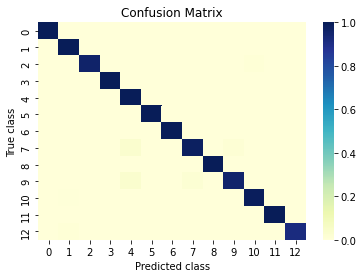

In [ ]:
# Disable grad
#turn off gradients computation
with torch.no_grad():
    # Retrieve item
    #item = dataset[index]
    gene = torch.from_numpy(d1_test)
    gene_label = torch.LongTensor(np.array(l1_test))
    inputs, labels = Variable(gene), Variable(gene_label)
    print(inputs.shape)
    
    # Generate prediction
    prediction = net(inputs)
    #print(prediction)
    
    # Predicted class value using argmax
    predicted_class =prediction.argmax(dim=1, keepdim=True)


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
print('Confusion matrix:')
print(confusion_matrix(labels, predicted_class))
print('F1 score: %f' % f1_score(labels, predicted_class, average='micro'))
print('Accuracy score: %f' % accuracy_score(labels, predicted_class))

Confusion matrix:
[[ 37   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 231   0   0   0   0   0   0   0   0   0   0   2]
 [  0   2  19   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   9   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  20   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0 172   0  17   0   0   0]
 [  0   1   0   0   0   0   0   0  11   1   2   0   0]
 [  0   0   0   0   0   0   0  15   0 112   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 101   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  25]]
F1 score: 0.946835
Accuracy score: 0.946835


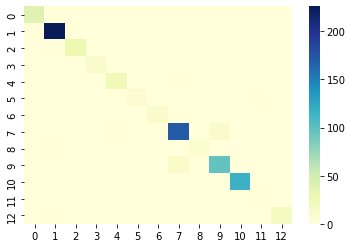

In [ ]:
import seaborn as sns
ax = sns.heatmap(confusion_matrix(labels, predicted_class), cmap="YlGnBu")
plt.xlabel("Predicted class")
plt.ylabel("True class")
ax.set_title(f'Confusion Matrix')
plt.show()
